In [2]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Using cached swig-4.1.1.post1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...
Selecting previously unselected package libgl1-mesa-glx:amd64.
(Reading database ... 122411 files and directories currently installed.)
Preparing to unpack .../libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Setting up libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-97rujz34
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-97rujz34
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit e58b160332627c81886c50b3f58e69e1b

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [3]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [4]:
# TRAIN_START_DATE = '2009-04-01'
# TRAIN_END_DATE = '2021-01-01'
# TEST_START_DATE = '2021-01-01'
# TEST_END_DATE = '2022-06-01'

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [5]:
df.shape

(97013, 8)

In [6]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.478999,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.817780,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.300198,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777557,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.523594,7325600,CAT,0


In [7]:
len(df.tic.unique())

30

In [8]:
df.tic.value_counts()

tic
AAPL    3311
AMGN    3311
WMT     3311
WBA     3311
VZ      3311
V       3311
UNH     3311
TRV     3311
PG      3311
NKE     3311
MSFT    3311
MRK     3311
MMM     3311
MCD     3311
KO      3311
JPM     3311
JNJ     3311
INTC    3311
IBM     3311
HON     3311
HD      3311
GS      3311
DIS     3311
CVX     3311
CSCO    3311
CRM     3311
CAT     3311
BA      3311
AXP     3311
DOW      994
Name: count, dtype: int64

In [9]:
#  INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']

In [10]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [11]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
89550,2022-04-07,44.430000,45.209999,43.700001,40.627449,9526400,WBA,3,-0.795739,44.717402,38.936782,43.393238,-104.129465,15.548318,41.950779,43.256400,16.222009
88669,2022-02-24,59.970001,60.619999,59.220001,56.973747,27207400,KO,3,0.394729,58.956959,56.256943,53.398115,-97.243676,20.016320,57.402475,55.784563,71.297520
76383,2020-06-19,57.349998,57.470001,56.000000,46.430134,28868200,VZ,4,0.165680,48.580293,44.871932,49.694447,35.839216,10.663314,46.353525,46.450901,31.433500
14991,2012-01-20,33.630001,33.650002,33.099998,22.947710,9156300,WBA,4,0.005024,23.781774,22.085545,49.676097,-21.230711,2.044611,23.018080,22.737977,107.384915
15168,2012-01-31,68.430000,68.709999,67.769997,49.726238,10033800,AMGN,1,1.277083,51.953986,46.306046,63.560372,74.086604,26.770881,48.099450,44.883352,21.331444


In [12]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [13]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [14]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

In [15]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000
                 }

In [16]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  201.7182202576237
======Model training from:  2010-01-01 to  2021-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
---------------------------------------
| time/                 |             |
|    fps                | 67          |
|    iterations         | 100         |
|    time_elapsed       | 7           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.1       |
|    explained_variance | -0.968      |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -7.81       |
|    reward             | 0.068202905 |
|    std                | 0.999       |
|    value_loss         | 1.21        |
---------------------------------------
-------------------------------------
| time/                 |          

In [17]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-10-04,2022-01-03,A2C,0.347778,0.234171,0.144754
1,189,2022-01-03,2022-04-04,A2C,-0.170571,-0.223199,-0.243723
2,252,2022-04-04,2022-07-06,DDPG,-0.271147,-0.224916,-0.188962
3,315,2022-07-06,2022-10-04,DDPG,-0.211621,-0.226555,-0.092764


In [18]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [19]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value,temp],ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.5620605319096545


In [20]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-01-03,NaN,2022-01-03
1,1.000454e+06,2022-01-04,0.000454,2022-01-04
2,9.963656e+05,2022-01-05,-0.004086,2022-01-05
3,9.916956e+05,2022-01-06,-0.004687,2022-01-06
4,9.872576e+05,2022-01-07,-0.004475,2022-01-07


<Axes: >

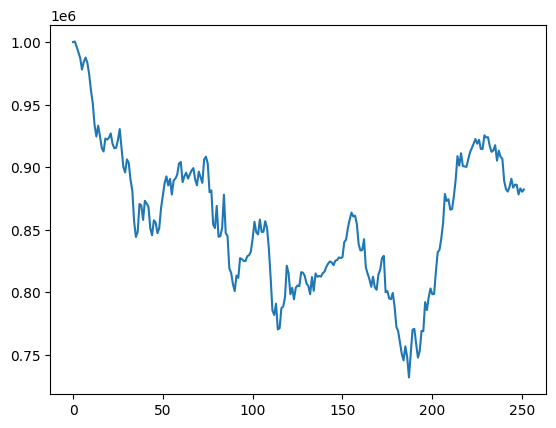

In [21]:
%matplotlib inline
df_account_value.account_value.plot()

In [22]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.117884
Cumulative returns    -0.117884
Annual volatility      0.191461
Sharpe ratio          -0.562061
Calmar ratio          -0.438962
Stability              0.104498
Max drawdown          -0.268552
Omega ratio            0.910082
Sortino ratio         -0.764812
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.977475
Daily value at risk   -0.024549
dtype: float64


In [23]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return         -0.094324
Cumulative returns    -0.093968
Annual volatility      0.198502
Sharpe ratio          -0.402058
Calmar ratio          -0.429901
Stability              0.236972
Max drawdown          -0.219408
Omega ratio            0.936015
Sortino ratio         -0.559755
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.014390
Daily value at risk   -0.025326
dtype: float64


In [24]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')

df_dji:             date           dji
0    2022-01-03  1.000000e+06
1    2022-01-04  1.005866e+06
2    2022-01-05  9.951360e+05
3    2022-01-06  9.904718e+05
4    2022-01-07  9.903404e+05
..          ...           ...
247  2022-12-27  9.086102e+05
248  2022-12-28  8.986103e+05
249  2022-12-29  9.080428e+05
250  2022-12-30  9.060324e+05
251  2023-01-03           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05
2022-01-07  9.903404e+05
...                  ...
2022-12-27  9.086102e+05
2022-12-28  8.986103e+05
2022-12-29  9.080428e+05
2022-12-30  9.060324e+05
2023-01-03           NaN

[252 rows x 1 columns]


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
348  2023-02-22
349  2023-02-23
350  2023-02-24
351  2023-02-27
352  2023-02-28

[353 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2022-01-03  1.000000e+06
2022-01-04  1.000454e+06
2022-01-05  9.963656e+05
2022-01-06  9.916956e+05
2022-01-07  9.872576e+05
...                  ...
2022-12-27  8.858701e+05
2022-12-28  8.781208e+05
2022-12-29  8.829353e+05
2022-12-30  8.803174e+05
2023-01-03  8.821159e+05

[252 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble           dji
date                                  
2022-01-03  1.000000e+06  1.000000e+06
2022-01-04  1.000454e+06  1.005866e+06
2022-01-05  9.963656e+05  9.951360e+05
2022-01-06  9.916956e+05  9.904718e+05
2022-01-07  9.872576e+05  9.903404e+05
...       

<Figure size 1500x500 with 0 Axes>

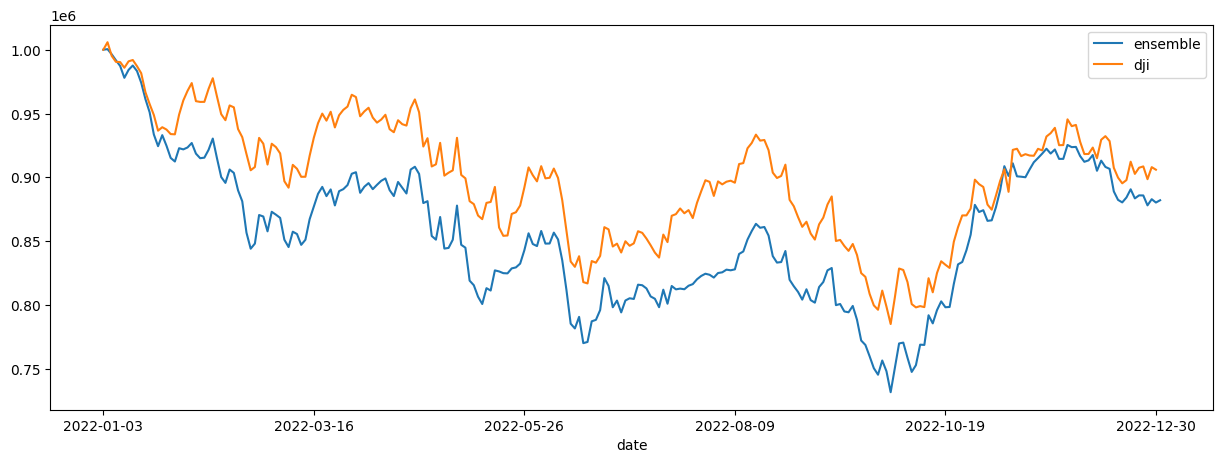

In [25]:
# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [16]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import datetime as datetime
from alpaca.data.live import StockDataStream
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import LimitOrderRequest
# #I make a cryptocurrency trading bot and hand it a $1000 dollars and leave it to trade that unsupervised for a week.

# # paper=True enables paper trading
trading_client = TradingClient('PKD45NSXOPC0O8N3DJ2A', '05cggpBpRk2uxh22gbHTQk3yBYU3qamZTL2OVFz5', paper=True)


##Market Order
# preparing orders
market_order_data = MarketOrderRequest(
                    symbol="NVDA",
                    qty=1,
                    side=OrderSide.SELL,
                    time_in_force=TimeInForce.DAY
                    )

# Market order
market_order = trading_client.submit_order(
                order_data=market_order_data
               )

# if(DRLEnsembleAGent.Sharpe > .4)

# # Market order
# market_order = trading_client.submit_order(fndsdsdsfdsdsf
#                 order_data=market_order_data
#                )

# else

# print(no trades for today)